In [1]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[=====================-----------------------------] 43.8% 728.4/1662.8MB downloaded

In [2]:
wv.similarity(w1="great", w2="good")

0.729151

In [3]:
wv_great = wv["great"]
wv_good = wv["good"]

In [4]:
wv_great.shape, wv_good.shape

((300,), (300,))

**Now we will use Genesim for news Classification**

In [5]:
import pandas as pd
df = pd.read_csv("fake_and_real_news.csv")
print(df.shape)
df.head(5)

(9900, 2)


,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [6]:
df['label_num'] = df['label'].map({'Fake' : 0, 'Real': 1})
df.head(5)

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,1


In [7]:
import spacy
nlp = spacy.load("en_core_web_lg") # if this fails then run "python -m spacy download en_core_web_lg" to download that model

def preprocess_and_vectorize(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
        
    return wv.get_mean_vector(filtered_tokens)

In [8]:
v = preprocess_and_vectorize("Don't worry if you don't understand")
v.shape

(300,)

In [9]:
df['vector'] = df['Text'].apply(lambda text: preprocess_and_vectorize(text))

In [10]:
df.head()

,Text,label,label_num,vector
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0,"[0.008657642, 0.019024342, -0.011917442, 0.032..."
1,U.S. conservative leader optimistic of common ...,Real,1,"[0.010864096, 0.007960429, 0.0011915653, 0.014..."
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1,"[0.018134918, 0.0062743523, -0.005872244, 0.03..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0,"[0.01255197, 0.012613623, 5.9780963e-05, 0.021..."
4,Democrats say Trump agrees to work on immigrat...,Real,1,"[-0.0019059887, 0.011889367, 0.0035395357, 0.0..."


In [11]:
from sklearn.model_selection import train_test_split


#Do the 'train-test' splitting with test size of 20% with random state of 2022 and stratify sampling too
X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values, 
    df.label_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df.label_num
)

In [13]:
import numpy as np
X_train_2d = np.stack(X_train)
X_test_2d =  np.stack(X_test)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

#1. creating a GradientBoosting model object
clf = GradientBoostingClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1000
           1       0.97      0.99      0.98       980

    accuracy                           0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980



Text(95.72222222222221, 0.5, 'Truth')

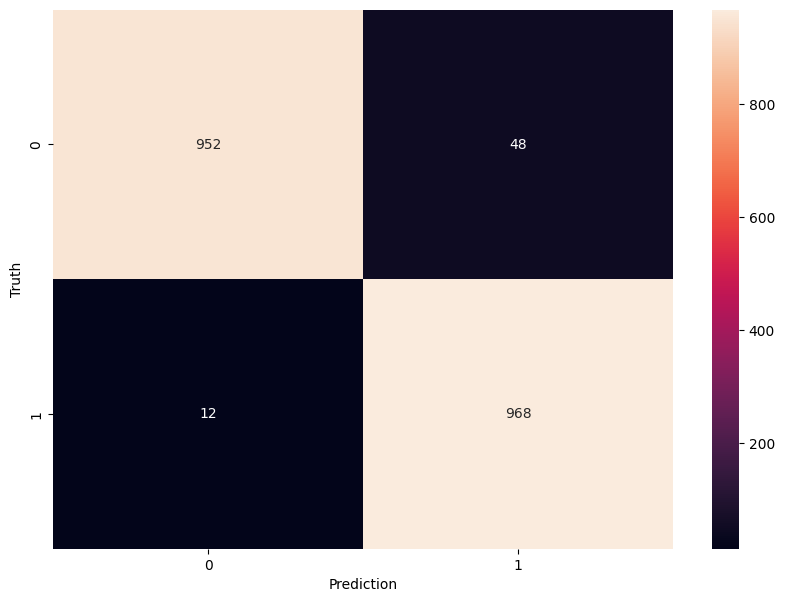

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm


from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')